<a href="https://colab.research.google.com/github/macfeel/Blogger/blob/main/%E7%94%BB%E5%83%8F%E3%82%92%E3%81%9F%E3%81%A0%E4%B8%A6%E3%81%B9%E3%81%9F%E3%81%84%E3%81%A8%E3%81%8D%E3%81%AB%E4%BD%BF%E3%81%88%E3%82%8BTorchVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

【参照】  
[画像をただ並べたいときに使えるTorchVision](https://blog.shikoan.com/torchvision-image-tile/)

### 想定状況

複数の画像を1枚に縦横に並べて表示したい、画像として保存したいというシチュエーションを想定します。ディープラーニングの場合は、画像を生成するようなモデルで中間結果を出力したいような場合ですね。

ただ、画像を並べる処理をそのたびに書いていくと、そこがバグ出やすいですし、コードのかなりの部分が出力生成に使われて見通しが効きにくくなったりします。特に、出力結果を訓練の終わりにだけ出すケースでは、長時間かけて訓練が全部終わり、画像の結合部分でバグが起き、全部おじゃんになるという非常に悲しい結果がある（経験済み）ので、ここらへんの処理はできればコピペ的に進めたいのです。

そんなとき便利かもしれないのが、TorchVisionのutilsです。torchvision.utils.make_gridという関数を使うとフルオートで画像を並べてくれます。
### 今回使うデータ

データを1から作ってみます。以下の9枚の単色塗りつぶしの画像を用意します。

In [ ]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch

# 9x9のカラー画像を作る
def create_color_images():
    images = np.zeros((9, 64, 64, 3), np.uint8) # NHWCのフォーマット
    # 0-2 = Red, Green, Blue
    images[0,:,:,0]=255
    images[1,:,:,1]=255
    images[2,:,:,2]=255
    # 3-5 = Yellow, Aqua, Fuchsia
    images[3,:,:,[0,1]] = 255
    images[4,:,:,[1,2]] = 255
    images[5,:,:,[0,2]] = 255
    # 6-8 = Olive, Teal, Purple
    images[6,:,:,[0,1]] = 128
    images[7,:,:,[1,2]] = 128
    images[8,:,:,[0,2]] = 128
    return images

左上から、「赤、緑、青、黄色、空色、フクシャ、オリーブ、ティール、紫色」の単色で塗った色です。よくあるやり方のように、pyplotのsubplotを使ってプロットしてみましょう。

In [ ]:
	%matplotlib inline

In [ ]:
# matplotlibでsubplot結合
def raw_pyplot():
    # データの読み込み
    images = create_color_images()
    # subplotを作る
    for i in range(images.shape[0]):
        ax = plt.subplot(3,3,i+1)
        ax.imshow(images[i])
        ax.axis("off")
    plt.show()

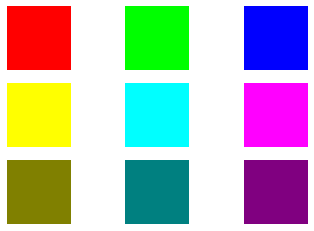

In [ ]:
raw_pyplot()

だいたいどんなイメージかわかったでしょうか。

### TorchVisionで1枚に並べてみる

TorchVisionを使って複数の画像を縦横に並べてみます。

In [ ]:
def torchvision_joint(n_row,n_padding):
    # データの読み込み
    images = create_color_images()
    # PyTorch用に, NHWC -> NCHW に変換
    images = np.transpose(images, [0,3,1,2])
    # PyTorchのテンソルにする（Numpy配列から作る場合はtorch.Tensorよりas_tensorのほうが良い）
    images_tensor = torch.as_tensor(images)
    # 一つの画像に統合
    # paddingの値→隙間, nrow=行あたりの画像数（端数は埋められる）
    joined_images_tensor = torchvision.utils.make_grid(
        images_tensor, nrow=n_row, padding=n_padding)
    # PyTorchのテンソル→Numpy配列
    joined_images = joined_images_tensor.numpy()
    # NCHW -> NHWCに変換
    return np.transpose(joined_images, [1,2,0])

def torchvision_plot(n_row,n_padding):
    jointed = torchvision_joint(n_row,n_padding)
    plt.imshow(jointed)
    plt.show()

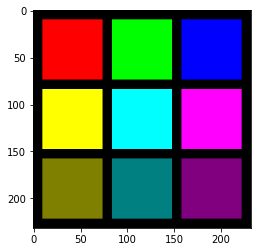

In [ ]:
torchvision_plot(3,10)

慣れない書き方なので順にコードを解説しましょう。まず入力は4次元のNumpy配列です。それぞれの軸は（どのサンプルか=N, 高さ=Height, 横=Width, カラーチャンネル=C）となります。Numpy配列の形式はuint8です。Pillowのインスタンスをnp.asarrayでNumpy配列に変換したときは1枚あたりがこの形式になります。正確にいうと、(H, W, C)の形式になるのでそれを束ねて4次元にしたものがこれです。

次に、テンソルの定義をPyTorchに合わせます。(N, H, W, C)を(N, C, H, W)に変換します。これはnp.transposeという関数でいけます。2番目の引数ですが、「0,3,1,2」は入れ替え前の軸のインデックスを、入れ替え後の並びになるように指定したものです。Nは変わらないので0, 次は元のインデックス3だったC、その次は元のインデックスが2だったH……。という具合です。

その次はPyTorchのテンソルに変換します。ここがちょっと面倒ですが、make_grid関数は生のNumpy配列を受け付けてくれないので、一回PyTorchのテンソルを経由させる必要があります。ただし、torch.Tensorでやったらfloat型にキャストされてしまい、pyplotでの表示上の明度が均一化されてしまったことがある（TorchVision:0.2.2, PyTorch:1.1.0）ので、Numpy配列から作る場合はtorch.as_tensorのほうが良さそうです。

次が本番のtorchvision.utils.make_gridの関数です。この関数によって複数の画像が1枚に合成され、縦横にタイルされます。n_rowはタイル1行あたりに表示する画像数、paddingは表示の間隔ですね（これはあとで変えて確かめてみます）。タイルする画像は全て同じ解像度である必要があります。

ただし、make_gridの返り値はPyTorchのテンソルなので、Numpy配列に戻します。「.numpy()」で一発です。

そして最初に(N, H, W, C)を(N, C, H, W)に変換したのを思い出しましょう。この逆変換をします。ただし、複数の画像が1枚に統合されているので、実際にやる作業は「(C, H, W)→(H, W, C)の変換」です。Hは元のインデックス1、Wはインデックス2、Cは0なので、np.transposeの2番目の引数は「1,2,0」となります。これで結合が終わりです。
### n_rowの値を変えると1行あたりの画像数が簡単に変更できる

コードの解説を読んで「逆に面倒臭いな」と思ったかもしれません。ここからがtorchvisionのすごいところなのですが、n_rowの引数を変えるだけで1行あたりの画像数が簡単に変更できます。make_gridのn_rowを2に変えてみました。

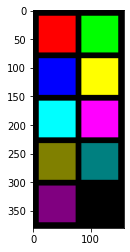

In [ ]:
torchvision_plot(2,10)

これはなかなかすごいです。n_row以外のコードは一切変えていません。端数分はいい感じに調整してくれます。

もしNumpy配列で1枚の黒塗り画像を用意して、逐一コピーしていたら、行列のインデックスがかなりややこしくなると思います（特に隙間の管理）。それを逐一デバッグするのは面倒ですよね？
### paddingの値を変えると画像間の間隔が変更できる

同様にして、make_gridのpaddingの値を30に変えてみました。

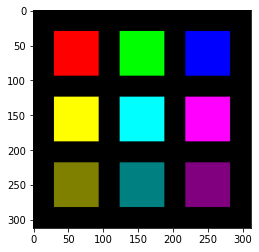

In [ ]:
torchvision_plot(3,30)

隙間が広くなりましたね。簡単です。
### 結合した画像を保存する場合

この方法でTorchVisionが最も効果を発揮するのは、結合した画像をファイルに保存する場合です。表示する場合よりコードが簡潔になります。

make_gridで1枚のNumpy配列を作って、それをPillowで変換して…ってやってもいいですが、純粋にtorchvision.utils.save_imageを使いましょう。内部でやっていることは、make_gridそのままで、PyTorchのテンソルからファイルの保存までを一発でやってくれます。

In [ ]:
def torchvision_save():
    # データの読み込み
    images = create_color_images()
    # save_imageで255掛けるため[0,1]スケールにしておく
    images = (images / 255.0).astype(np.float32)
    # 1枚に結合
    images = np.transpose(images, [0,3,1,2])
    images_tensor = torch.as_tensor(images)
    torchvision.utils.save_image(images_tensor, "jointed_image.png",
                                 nrow=3, padding=10)

In [ ]:
torchvision_save()